In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
%matplotlib inline

# K-nearest neighbors classifiers

So far, this program has covered learning via linear classifiers (logistic regression) and learning via errors (linear regression). In this lesson, you'll look at learning via similarity. This means that you will look for the data points that are most similar to the observation that you are trying to predict.

Start with the simplest method: the *nearest neighbor* method.

## Nearest neighbor

For this example, your challenge is to classify a song as either `rock` or `jazz`. For this data, you have measures of duration in seconds, and measures of loudness in loudness units. (You're not going to be using decibels because that isn't a linear measure, so it would create some problems that you'll get into later.)

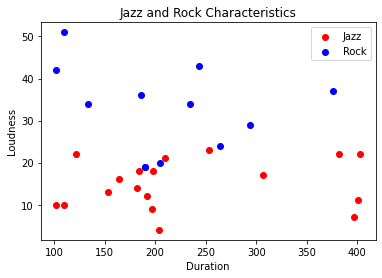

In [2]:
music = pd.DataFrame()

# Some data to play with
music['duration'] = [184, 134, 243, 186, 122, 197, 294, 382, 102, 264, 
                     205, 110, 307, 110, 397, 153, 190, 192, 210, 403,
                     164, 198, 204, 253, 234, 190, 182, 401, 376, 102]
music['loudness'] = [18, 34, 43, 36, 22, 9, 29, 22, 10, 24, 
                     20, 10, 17, 51, 7, 13, 19, 12, 21, 22,
                     16, 18, 4, 23, 34, 19, 14, 11, 37, 42]

# You know whether the songs in the training data are jazz or not
music['jazz'] = [ 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
                  0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
                  1, 1, 1, 1, 0, 0, 1, 1, 0, 0]


# Look at the data
plt.scatter(
    music[music['jazz'] == 1].duration,
    music[music['jazz'] == 1].loudness,
    color='red'
)
plt.scatter(
    music[music['jazz'] == 0].duration,
    music[music['jazz'] == 0].loudness,
    color='blue'
)
plt.legend(['Jazz', 'Rock'])
plt.title('Jazz and Rock Characteristics')
plt.xlabel('Duration')
plt.ylabel('Loudness')
plt.show()

The simplest form of a similarity model is the nearest neighbor model. This works in a straightforward way: when you're trying to predict an observation, find the closest (or *nearest*) known observation in the training data and use that value to make your prediction. Here you'll use the model as a classifier. The outcome of interest will be a category.

To find which observation is "nearest," you need some kind of way to measure distance. Typically, data scientists use *Euclidean distance*, which is the standard distance measure that you may be familiar with from geometry. With two observations—$(x_1, x_2, ...,x_n)$ and $(w_1, w_2,...,w_n)$—in $n$ dimensions, you have the following distance equation:

$$ \sqrt{(x_1-w_1)^2 + (x_2-w_2)^2+...+(x_n-w_n)^2} $$

You might recognize this formula (taking distances, squaring them, adding the squares together, and taking the root) as a generalization of the [Pythagorean theorem](https://en.wikipedia.org/wiki/Pythagorean_theorem) into $n$ dimensions. You can technically define any distance measure that you want, and there are times where this customization may be valuable. As a general standard, however, you'll use Euclidean distance.

Now that you have a distance measure from each point in the training data to the point that you're trying to predict, the model can find the data point with the smallest distance and then apply that category to your prediction.

Try running this model using the scikit-learn package:

In [3]:
from sklearn.neighbors import KNeighborsClassifier
neighbors = KNeighborsClassifier(n_neighbors=1)
X = music[['loudness', 'duration']]
Y = music.jazz
neighbors.fit(X,Y)

## Predict for a song with 24 loudness that's 190 seconds long.
neighbors.predict([[24, 190]])

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([0])

It's as simple as that. It looks like the model is predicting that a 24-loudness, 190-second-long song isn't jazz. All it takes to train the model is a DataFrame of independent variables and a DataFrame of dependent outcomes.

You'll note that this example used the `KNeighborsClassifier()` method from scikit-learn. This is because nearest neighbor is a simplification of K-nearest neighbors. The jump, however, isn't that far.

## K-nearest neighbors

*K-nearest neighbors* (or KNN) is the logical extension of nearest neighbor. Instead of looking at just the single nearest data point to predict an outcome, you look at several of the nearest neighbors, with $k$ representing the number of neighbors that you choose to look at. Each of the $k$ neighbors gets to vote on what the predicted outcome should be.

This does a couple of valuable things. Firstly, it smooths out the predictions. If only one neighbor gets to influence the outcome, the model explicitly overfits to the training data. Any single outlier can create pockets of one category prediction surrounded by a sea of the other category.

This also means that instead of just predicting classes, you get implicit probabilities. If each of the $k$ neighbors gets a vote on the outcome, then the probability of the test example being from any given class $i$ is as follows:
$$ \frac{votes_i}{k} $$

This applies for all classes present in the training set. This example only has two classes, but this model can accommodate as many classes as the dataset necessitates. To come up with a classifier prediction, it simply takes the class for which that fraction is maximized.

Now, expand the initial nearest neighbors model from above to a KNN model with a $k$ of `5`.

In [4]:
neighbors = KNeighborsClassifier(n_neighbors=5)
X = music[['loudness', 'duration']]
Y = music.jazz
neighbors.fit(X,Y)

## Predict for a 24-loudness, 190-second-long song.
print(neighbors.predict([[24, 190]]))
print(neighbors.predict_proba([[24, 190]]))

[1]
[[ 0.4  0.6]]


Now the test prediction has changed. In using the five nearest neighbors, it appears that there were two votes for rock and three for jazz, so it was classified as a jazz song. This is different from the simpler nearest neighbors model. Although the closest observation was in fact rock, there are more jazz songs in the nearest $k$ neighbors than rock.

You can visualize your decision bounds with something called a *mesh*, which allows you to generate a prediction over the whole space. Read the code below and make sure that you can identify what the individual lines do. If necessary, consult the documentation for unfamiliar methods.

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


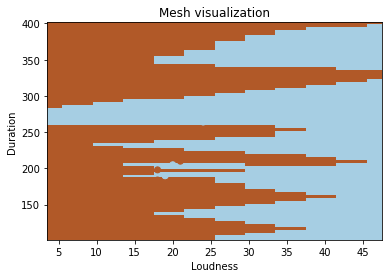

In [5]:
# The data. Converting from DataFrames to arrays for the mesh.
X = np.array(X)
Y = np.array(Y)

# Mesh size
h = 4.0

# Plot the decision boundary and assign a color to each point in the mesh
x_min = X[:, 0].min() - .5
x_max = X[:, 0].max() + .5
y_min = X[:, 1].min() - .5
y_max = X[:, 1].max() + .5
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h)
)
Z = neighbors.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(6, 4))
plt.set_cmap(plt.cm.Paired)
plt.pcolormesh(xx, yy, Z)

# Add the training points to the plot
plt.scatter(X[:, 0], X[:, 1], c=Y)
plt.xlabel('Loudness')
plt.ylabel('Duration')
plt.title('Mesh visualization')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()

Looking at the visualization above, any new point that fell within a blue area would be predicted to be jazz, and any point that fell within a brown area would be predicted to be rock.

The boundaries above are strangely jagged here, and you'll get into that in more detail in the next lesson.

Also note that the visualization isn't completely continuous. There are an infinite number of points in this space, and you can't calculate the value for each one. That's where the mesh comes in. Above, the mesh size was set to 4.0 (`h = 4.0`), which means that you calculate the value for each point in a grid where the points are spaced 4.0 away from each other.

You can make the mesh size smaller to get a more continuous visualization, but that comes at the cost of a more computationally demanding calculation. In the cell below, recreate the plot above with a mesh size of 10.0. Then reduce the mesh size until you get a plot that looks good but still renders in a reasonable amount of time. When do you get a visualization that looks acceptably continuous? When do you start to get a noticeable delay?

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


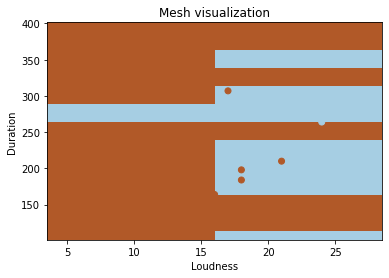

In [12]:
# Play with different mesh sizes here

# The data. Converting from DataFrames to arrays for the mesh.
X = np.array(X)
Y = np.array(Y)

# Mesh size
h = 25.0

# Plot the decision boundary and assign a color to each point in the mesh
x_min = X[:, 0].min() - .5
x_max = X[:, 0].max() + .5
y_min = X[:, 1].min() - .5
y_max = X[:, 1].max() + .5
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h)
)
Z = neighbors.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(6, 4))
plt.set_cmap(plt.cm.Paired)
plt.pcolormesh(xx, yy, Z)

# Add the training points to the plot
plt.scatter(X[:, 0], X[:, 1], c=Y)
plt.xlabel('Loudness')
plt.ylabel('Duration')
plt.title('Mesh visualization')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()

Now you've built a KNN model!

## Challenge: Implement the nearest neighbor algorithm 

The nearest neighbor algorithm is extremely simple. So simple, in fact, that you should be able to build it yourself from scratch using the Python that you already know. Code a nearest neighbors algorithm that works for two-dimensional data. You can use either arrays or DataFrames to do this. Then test it against the scikit-learn package on the music dataset from above to ensure that it's correct. The goal here is to confirm your understanding of the model and continue to practice your Python skills. You can simply use a brute force method here. After doing this, look up "ball tree" methods to see a more performant algorithm design.

In [50]:
# Your nearest neighbor algorithm here

music = pd.DataFrame()
music['duration'] = [184, 134, 243, 186, 122, 197, 294, 382, 102, 264, 205, 110, 307, 110, 397, 153, 190, 192, 210, 403, 164, 198, 204, 253, 234, 190, 182, 401, 376, 102]
music['loudness'] = [18, 34, 43, 36, 22, 9, 29, 22, 10, 24, 20, 10, 17, 51, 7, 13, 19, 12, 21, 22, 16, 18, 4, 23, 34, 19, 14, 11, 37, 42]
music['jazz'] = [ 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0]

def knn_music (neighbors, target, data):
    result = 0
    result_chance = -100
    
    # distance column
    data['value'] = pd.Series(dtype = 'float64')
    
    # calculate distance
    for index, row in data.iterrows():
        dist = np.sqrt( ((target[0] - data.loc[index, 'duration']) * (target[0] - data.loc[index, 'duration'])) + 
                        ((target[1] - data.loc[index, 'loudness']) * (target[1] - data.loc[index, 'loudness'])) )
        data.loc[index, 'value'] = dist
        
    # nearest values first    
    data_sorted = data.sort_values(by = 'value', ascending = True)
    
    # determine result (percent chance song is jazz, flip if under .5)
    for index in range(neighbors):
        result += data_sorted.loc[index, 'jazz']
        
    result_chance = result / neighbors
    
    if result_chance < .5:
        result = 0
        result_chance = 1 - result_chance
    else:
        result = 1
    
    print(result, result_chance)
    

knn_music(1, [24, 190], music)
knn_music(5, [24, 190], music)

# Same odds but getting 3 rock songs as nearest neighbors and 2 jazz songs.

1 1.0
0 0.6
